Import des librairies nécessaires

In [526]:
import math
from enum import Enum

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray


Variables globales

In [527]:
PICTURE_SIZE_SHEET_DETECTION = 1000

Fonctions utilitaires

In [528]:
def show_image(image: ndarray, cmap: str = None, title: str = None):
    # Convert BGR to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()
    
def to_radians(angle):
    return angle * math.pi / 180
    
def rotate_point(center, point, angle):
    s = math.sin(angle)
    c = math.cos(angle)

    # Translate point back to origin
    translated_x = point[0] - center[0]
    translated_y = point[1] - center[1]

    # Rotate point
    rotated_x = translated_x * c - translated_y * s
    rotated_y = translated_x * s + translated_y * c

    # Translate point back
    new_point = (rotated_x + center[0], rotated_y + center[1])

    return new_point


def get_point_on_ellipse(ellipse, angle):
    center, radii,ellipse_angle = ellipse
    radius_x, radius_y = radii
    x = center[0] + math.cos(angle) * (radius_x /2)
    y = center[1] + math.sin(angle) * (radius_y /2)
    rotated_point = rotate_point(center, (x, y),to_radians(ellipse_angle) + to_radians(180))
    # Convert the coordinates to integers
    return (int(x), int(y))

def grow_ellipse(ellipse, factor):
    center, radii, angle = ellipse
    return (center, (radii[0] * factor, radii[1] * factor), angle)

Positions des visuels sur le plastron

In [529]:
class Zone(Enum):
    TOP_LEFT = 1
    TOP_RIGHT = 2
    BOTTOM_LEFT = 3
    BOTTOM_RIGHT = 4
    CENTER = 5

Récupération des coordonnées du plastron sur une image

In [530]:
def enhance_image_for_edge_detection(image: ndarray, blur_radius: int = 0):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    if blur_radius > 0:
        v = cv.blur(v, (blur_radius, blur_radius))
    return v


def get_edges(image: ndarray, blur_radius: int = 0, canny_threshold_1: int = 100, canny_threshold_2: int = 200):
    image_clone = image.copy()
    if blur_radius > 0:
        image_clone = cv.blur(image_clone, (blur_radius, blur_radius))
    return cv.Canny(image_clone, canny_threshold_1, canny_threshold_2)


def get_biggest_valid_contour(contours):
    biggest_contour = None
    biggest_area = 0
    for contour in contours:
        approx = cv.approxPolyDP(contour, cv.arcLength(contour, True) * 0.01, True)
        if len(approx) != 4 or cv.contourArea(approx) < biggest_area:
            continue
        angles = [math.acos(((p1[0] - p2[0]) * (p3[0] - p2[0]) + (p1[1] - p2[1]) * (p3[1] - p2[1])) /
                            (((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5 *
                             ((p3[0] - p2[0]) ** 2 + (p3[1] - p2[1]) ** 2) ** 0.5)) * 180 / math.pi
                  for i in range(4)
                  for p1, p2, p3 in [(approx[i][0], approx[(i + 1) % 4][0], approx[(i + 2) % 4][0])]]
        if any(angle < 70 or angle > 110 for angle in angles):
            continue
        area = cv.contourArea(approx)
        if area / (PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) < 0.1 or area / (
                PICTURE_SIZE_SHEET_DETECTION * PICTURE_SIZE_SHEET_DETECTION) > 0.9:
            continue
        biggest_contour = approx
        biggest_area = area
    return biggest_contour


def coordinates_to_percentage(coordinates, width, height):
    percentage_coordinates = []
    for coordinate in coordinates:
        percentage_coordinates.append((coordinate[0] / width, coordinate[1] / height))
    return percentage_coordinates


def get_sheet_coordinates(sheet_mat: ndarray):
    # Enhance image for edge detection
    enhanced_image = enhance_image_for_edge_detection(
        cv.resize(sheet_mat.copy(), (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION)),
        blur_radius=5
    )

    # Get edges and dilate them
    dilated_edges = cv.dilate(
        get_edges(cv.bitwise_not(enhanced_image), blur_radius=5),
        cv.getStructuringElement(cv.MORPH_RECT,
                                 (int(PICTURE_SIZE_SHEET_DETECTION / 90), int(PICTURE_SIZE_SHEET_DETECTION / 90))),
        iterations=2
    )

    # Find contours
    contours, _ = cv.findContours(cv.bitwise_not(dilated_edges), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = get_biggest_valid_contour(contours)
    if biggest_contour is None:
        return None

    # Get coordinates of the biggest contour and convert to percentage
    return coordinates_to_percentage(
        [(biggest_contour[i][0][0], biggest_contour[i][0][1]) for i in range(4)],
        PICTURE_SIZE_SHEET_DETECTION,
        PICTURE_SIZE_SHEET_DETECTION
    )

Test de la récupération des coordonnées du plastron

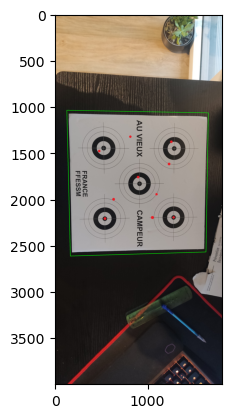

In [531]:
image = cv.imread('images/sheet.jpg')
coordinates = get_sheet_coordinates(image)


def draw_sheet_detection_contour(image, coordinates):
    coordinates_len = len(coordinates)
    for i in range(coordinates_len):
        cv.line(image, coordinates[i], coordinates[(i + 1) % coordinates_len], (0, 255, 0), 3)


def percentage_to_coordinates(percentage_coordinates, width, height):
    coordinates = []
    for percentage_coordinate in percentage_coordinates:
        coordinates.append((int(percentage_coordinate[0] * width), int(percentage_coordinate[1] * height)))
    return coordinates


if coordinates is not None:
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)
    draw_sheet_detection_contour(image, real_coordinates)
    show_image(image)
else:
    print('No coordinates found')

Extraction de l'image du plastron

In [532]:
def get_sheet_picture(image: ndarray):
    coordinates = get_sheet_coordinates(image)
    if coordinates is None:
        return None
    height, width, _ = image.shape
    real_coordinates = percentage_to_coordinates(coordinates, width, height)

    approx = np.array(real_coordinates, np.float32)
    target_coordinates = np.array([
        [0, 0],
        [PICTURE_SIZE_SHEET_DETECTION, 0],
        [PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION], [0, PICTURE_SIZE_SHEET_DETECTION]
    ], np.float32)
    transformation_matrix = cv.getPerspectiveTransform(approx, target_coordinates)
    sheet_mat = cv.warpPerspective(image, transformation_matrix,
                                   (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION))

    return sheet_mat

Test de l'extraction de l'image du plastron

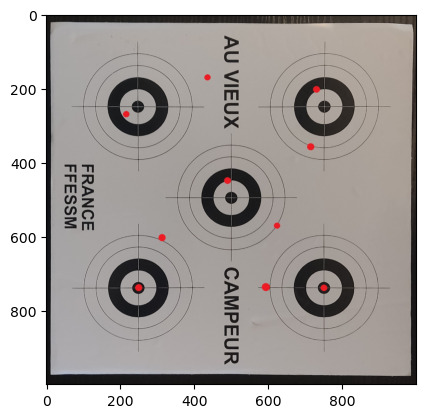

In [533]:
image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
show_image(sheet_mat)

Extraction d'un visuel du plastron

In [534]:
def get_crop_coordinates(image: ndarray, target_zone: Zone):
    height, width, _ = image.shape
    x1, x2, y1, y2 = 0, width, 0, height

    if target_zone in [Zone.TOP_RIGHT, Zone.BOTTOM_RIGHT]:
        x1 = int(width / 2)
    if target_zone in [Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]:
        y1 = int(height / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.BOTTOM_LEFT]:
        x2 = int(width / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.TOP_RIGHT]:
        y2 = int(height / 2)
    if target_zone == Zone.CENTER:
        x1, y1 = int(width / 4), int(height / 4)
        x2, y2 = width - x1, height - y1

    return {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2}


def get_target_picture(sheet_mat: ndarray, target_zone: Zone):
    sheet_mat_clone = sheet_mat.copy()
    coordinates = get_crop_coordinates(sheet_mat_clone, target_zone)
    return sheet_mat_clone[coordinates['x1']:coordinates['x2'], coordinates['y1']:coordinates['y2']]


Test de l'extraction des visuels du plastron

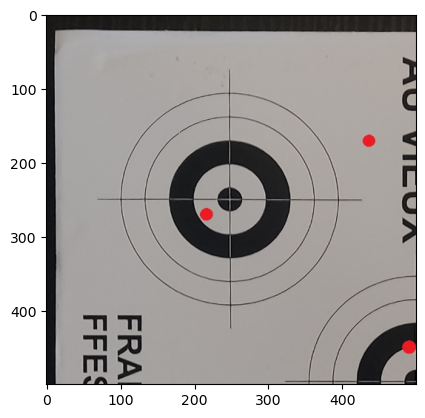

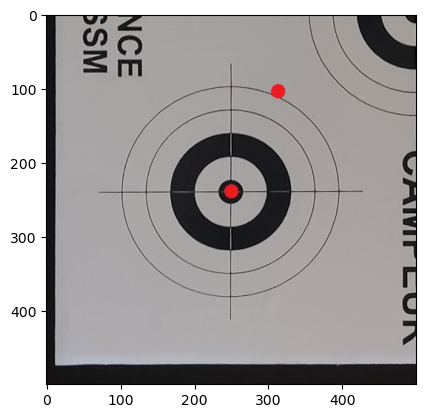

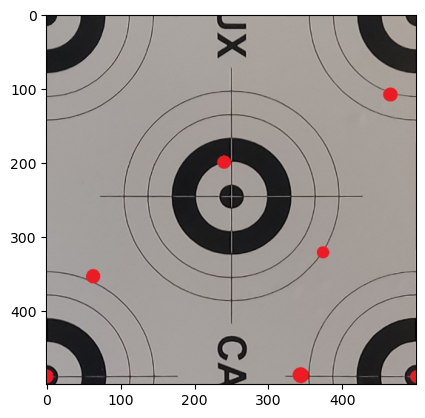

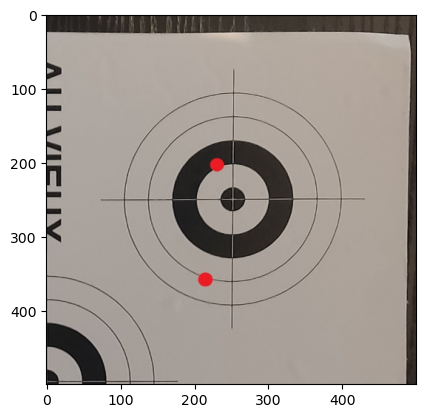

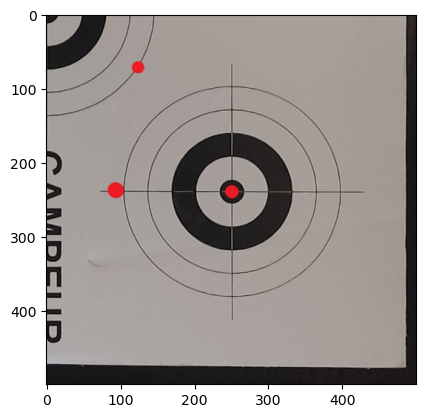

In [535]:
zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
for zone in zones:
    target_mat = get_target_picture(sheet_mat, zone)
    show_image(target_mat)



Récupération de la couleur des piges

In [536]:
def get_biggest_contour(contours):
    max_area = 0
    biggest_contour = None
    for contour in contours:
        bounding_rect = cv.boundingRect(contour)
        area = bounding_rect[2] * bounding_rect[3]
        if area > max_area:
            max_area = area
            biggest_contour = contour
    return biggest_contour


def get_impacts_mask(image: ndarray):
    image = cv.blur(image.copy(), (PICTURE_SIZE_SHEET_DETECTION // 100, PICTURE_SIZE_SHEET_DETECTION // 100))
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(saturation)
    min_val = (max_val - min_val) / 1.4 + min_val

    lower_bound = np.array([min_val], dtype=np.uint8)
    upper_bound = np.array([max_val], dtype=np.uint8)

    low = np.full((saturation.shape[0], saturation.shape[1]), lower_bound, dtype=np.uint8)
    high = np.full((saturation.shape[0], saturation.shape[1]), upper_bound, dtype=np.uint8)

    cv.inRange(saturation, low, high, saturation)

    contours, hierarchy = cv.findContours(saturation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # create a mask image that contains the contour filled in
    mask = np.zeros_like(saturation)  # Create mask where white is what we want, black otherwise
    cv.drawContours(mask, contours, -1, 255, -1)  # Draw filled contour in mask
    return mask


Test de la récupération du masque des piges

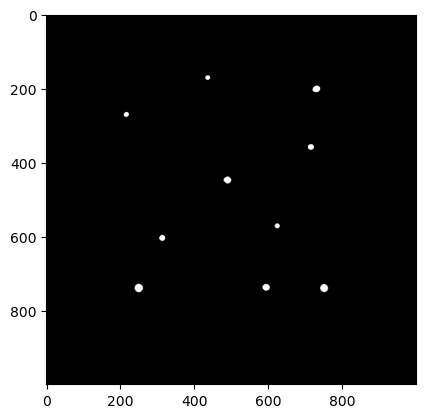

In [537]:
image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
color = get_impacts_mask(sheet_mat)
show_image(color, cmap='gray')

Récupération des coordonnées des piges

In [538]:
def get_impacts_coordinates(image: ndarray) -> list:
    mask = get_impacts_mask(image)
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    ellipses = [cv.fitEllipse(contour) for contour in contours]
    # get ellipses centers
    centers = [(int(ellipse[0][0]), int(ellipse[0][1])) for ellipse in ellipses]
    return centers



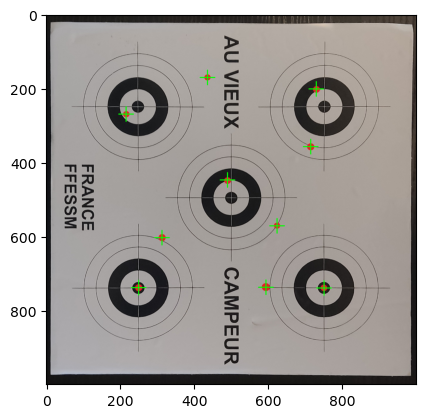

In [539]:
image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
coordinates = get_impacts_coordinates(sheet_mat)
# draw centers on the sheet
for coordinate in coordinates:
    #draw a cross at the given coordinate
    cross_color = (0, 255, 0)
    cross_size = 20
    cross_width = 2
    cv.line(sheet_mat, (coordinate[0] - cross_size, coordinate[1]), (coordinate[0] + cross_size, coordinate[1]),
            cross_color,
            cross_width)
    cv.line(sheet_mat, (coordinate[0], coordinate[1] - cross_size), (coordinate[0], coordinate[1] + cross_size),
            cross_color, cross_width)
show_image(sheet_mat)

Récupération d'un masque de la couleur des piges (ou de toutes autres couleurs)

In [540]:
def get_color_mask(mat: ndarray, color: tuple):
    color_mat = np.full((1, 1, 3), color, dtype=np.uint8)
    hsv = cv.cvtColor(color_mat, cv.COLOR_RGB2HSV)
    min_val = np.array([hsv[0][0][0] - 10, 100, 50], dtype=np.uint8)
    max_val = np.array([hsv[0][0][0] + 10, 255, 255], dtype=np.uint8)
    hsv_mat = cv.cvtColor(mat, cv.COLOR_BGR2HSV)
    min_mat = np.full((hsv_mat.shape[0], hsv_mat.shape[1], 3), min_val, dtype=np.uint8)
    high_mat = np.full((hsv_mat.shape[0], hsv_mat.shape[1], 3), max_val, dtype=np.uint8)
    mask = cv.inRange(hsv_mat, min_mat, high_mat)
    kernel = np.ones((PICTURE_SIZE_SHEET_DETECTION // 200, PICTURE_SIZE_SHEET_DETECTION // 200), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1)
    _, mask = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)
    return mask

Récupération de la position d'un visuel sur le plastron

In [541]:
def get_target_ellipse(mat):
    circle = np.zeros((mat.shape[1], mat.shape[0]), dtype=np.uint8)
    cv.circle(circle, (mat.shape[1] // 2, mat.shape[0] // 2), int(mat.shape[1] / 2.2), (255, 255, 255), -1)

    kernel_size = PICTURE_SIZE_SHEET_DETECTION // 200
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
    hsv = cv.cvtColor(mat.copy(), cv.COLOR_BGR2HSV)
    hsv_channels = cv.split(hsv)
    value = hsv_channels[2]

    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(value)
    max_val = (max_val - min_val) / 2 + min_val

    min_mat = np.full((value.shape[0], value.shape[1]), min_val, dtype=value.dtype)
    high_mat = np.full((value.shape[0], value.shape[1]), max_val, dtype=value.dtype)
    value_mask = cv.inRange(value, min_mat, high_mat)
    cv.bitwise_and(value_mask, circle, value_mask)

    close = cv.morphologyEx(value_mask, cv.MORPH_CLOSE, kernel)
    close = cv.morphologyEx(close, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(close, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    biggest_contour = max(contours, key=cv.contourArea)
    ellipse = cv.fitEllipse(biggest_contour)
    for i in range(10):
        empty = np.zeros(mat.shape, dtype=np.uint8)
        cv.ellipse(empty, ellipse, (255, 255, 255), -1)
        empty_gray = cv.cvtColor(empty, cv.COLOR_BGR2GRAY)
        
        xor = cv.bitwise_xor(empty_gray, close)
        cv.bitwise_or(close, xor, xor)
        contours, _ = cv.findContours(xor, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        biggest_contour = max(contours, key=cv.contourArea)
        ellipse = cv.fitEllipse(biggest_contour)
        if ellipse[1][0] < ellipse[1][1] * 0.7 or ellipse[1][0] > ellipse[1][1] * 1.3:
            raise ValueError('Problem during visual detection')
    return ellipse

Récupération de l'emplacement des visuels sur le plastron

In [542]:
def get_targets_ellipse(image: ndarray):
    zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT, Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
    ellipsis = {}
    for zone in zones:
        target_mat = get_target_picture(image, zone)
        ellipsis[zone] = get_target_ellipse(target_mat)
    return ellipsis

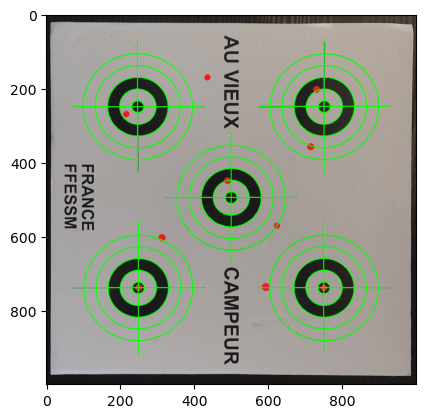

In [543]:
def target_coordinates_to_sheet_coordinates(ellipsis: dict):
    new_ellipsis = {}
    for key, value in ellipsis.items():
        if (key == Zone.TOP_LEFT):
            new_ellipsis[key] = (value[0], value[1], value[2])
        elif (key == Zone.TOP_RIGHT):
            new_ellipsis[key] = ((value[0][0], value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 2), value[1], value[2])
        elif (key == Zone.BOTTOM_LEFT):
            new_ellipsis[key] = ((value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 2, value[0][1]), value[1], value[2])
        elif (key == Zone.BOTTOM_RIGHT):
            new_ellipsis[key] = (
            (value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 2, value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 2),
            value[1], value[2])
        elif (key == Zone.CENTER):
            new_ellipsis[key] = (
            (value[0][0] + PICTURE_SIZE_SHEET_DETECTION // 4, value[0][1] + PICTURE_SIZE_SHEET_DETECTION // 4),
            value[1], value[2])
    return new_ellipsis


image = cv.imread('images/sheet.jpg')
sheet_mat = get_sheet_picture(image)
coordinates = get_targets_ellipse(sheet_mat)
coordinates = target_coordinates_to_sheet_coordinates(coordinates)
#iterate key and value
for key, ellipse_contrat in coordinates.items():
    
    drawing_width = 2
    
    # Draw the ellipse
    target_color = (0, 255, 0)
    # Grow the ellipse
    ellipse_cross_tip = grow_ellipse(ellipse_contrat, 2.2)
    ellipse_mouche = grow_ellipse(ellipse_contrat, 0.2)
    ellipse_petit_blanc = grow_ellipse(ellipse_contrat, 0.6)
    ellipse_moyen_blanc = grow_ellipse(ellipse_contrat, 1.4)
    ellipse_grand_blanc = grow_ellipse(ellipse_contrat, 1.8)
    # Draw the ellipses
    cv.ellipse(sheet_mat, ellipse_contrat, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_mouche, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_petit_blanc, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_moyen_blanc, target_color, drawing_width)
    cv.ellipse(sheet_mat, ellipse_grand_blanc, target_color, drawing_width)
    
    
    
    top_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(90))
    bottom_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(270))
    left_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(180))
    right_point = get_point_on_ellipse(ellipse_cross_tip, to_radians(0))
    cv.line(sheet_mat, top_point, bottom_point, target_color, drawing_width)
    cv.line(sheet_mat, left_point, right_point, target_color, drawing_width)
show_image(sheet_mat)